# $k$ Means

This section is the immediate extension from two means to $k$ means. 

The name ANOVA is sometimes used in this setting. ANOVA stands for analysis of analysis of variance, but should be more literally translated to comparing $k$ levels' means.  The reason behind the name ANOVA is that often, but not in this class, the variation amongst the groups compared to variation within the groups gives a reasonable decision rule for determinging when means by level are different.

We continue to work with the dataset $\texttt{carnivora}$.  Now we'll estimate a mean for $k = 4$ of the levels of the categorical variable $\texttt{Family}$: Canidae, Felidae, Mustelidae, and Viverridae. For the body weight data, $\texttt{SW}$, we assume

$$ Y_1, \ldots, Y_N \sim_{iid} \text{Normal}(\mu, \sigma^2) \\
\mu = \beta_0 + \beta_1 * Felidae + \beta_2 * Mustelidae + \beta_3 * Viverridae.$$

Let's plot our data and add the mean as a new layer, now that we're getting good at plotting.  The code below first carefully removes missing data and filters our dataset down to the levels of interest.

In [40]:
library(ggplot2)
carnivora <- read.csv("https://raw.githubusercontent.com/roualdes/data/master/carnivora.csv")

In [41]:
# HIDDEN
update_geom_defaults("point", list(colour = "blue"))
update_geom_defaults("density", list(colour = "blue"))
update_geom_defaults("path", list(colour = "blue"))
old <- theme_set(theme_bw() + theme(text = element_text(size=18)))

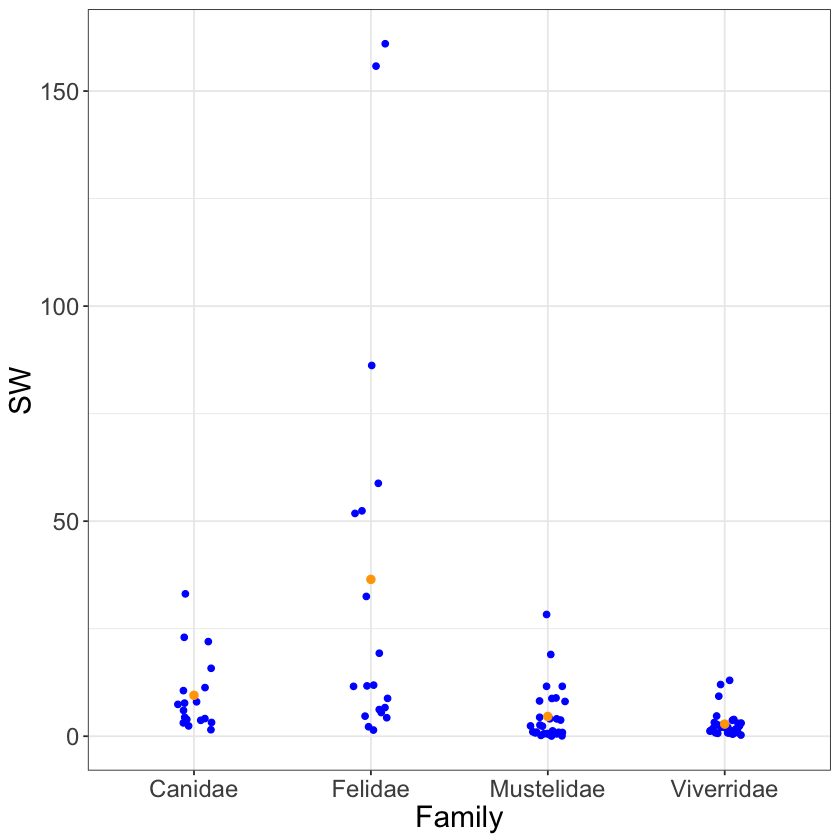

In [42]:
library(dplyr)
carn <- carnivora %>%
    select(Family, SW) %>%
    filter(Family %in% c("Canidae", "Felidae", "Mustelidae", "Viverridae")) %>%
    droplevels

ggplot(carn, aes(Family, SW)) + 
    geom_jitter(width=.1) +
    stat_summary(fun.y="mean", color="orange", geom="point", size=2)



From the plot above, it seems like Felidae has the greatest mean weight, but it also seems like there is the most variation in Felidae.

Code to fit our model above looks quite similar to our previous efforts in Sections Simple Linear Regression and Two Means.

In [43]:
ll <- function(beta, y, mX) {
    sum((y - apply(mX, 1, function(row) {sum(beta * row)}))^2)
}
X <- model.matrix( ~ Family, data=carn)

(beta <- optim(rexp(4), ll, method="L-BFGS-B", mX=X, y=carn$SW)$par)

[1]  9.511245 26.947827 -4.915414 -6.699961

The same trick is taking place in our model.  The "intercept" is really the first level's mean, Canidae.  Each coefficient after that is a level-specific offset relative to the Canidae's mean.  To find, say, Mustelidae's mean, you have to add $\hat{\beta}_0$ to $\hat{\beta}_2$.

In [44]:
beta[1] + beta[3]

[1] 4.595831

These estimates are still no different than group means.  Don't be discouraged, we are building to more complex models than group means.  Nonetheless, here's the empirical evidence.

In [45]:
carn %>%
    group_by(Family) %>%
    summarise(mnSW = mean(SW))

Family,mnSW
Canidae,9.511111
Felidae,36.458947
Mustelidae,4.595667
Viverridae,2.811250


Quantifying uncertainty in our estimates is carried out with the bootstrap method.

In [46]:
library(boot)

breg <- function(data, idx) {
    y <- data[idx, 1]
    X <- data[idx, -1]
    optim(rexp(4), ll, method="L-BFGS-B", mX=X, y=y)$par
}

b <- boot(cbind(carn$SW, X), R=999, breg)
bci_beta0 <- boot.ci(b, conf=.95, type="perc", index=1)
bci_beta1 <- boot.ci(b, conf=.95, type="perc", index=2)